## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
data = pd.read_csv("ab_data.csv")
data.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
data.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
uniqueUsers = data["user_id"].nunique()
uniqueUsers

290584

d. The proportion of users converted.

In [5]:
convertedUsers = data[data.converted == 1]["user_id"].nunique()
convertedUsers / uniqueUsers

0.12104245244060237

In [6]:
#Just checking here to see if what I did above is similar.
convertedUsers = data[data.converted == 1]["user_id"].shape[0]
convertedUsers / uniqueUsers

0.12126269856564711

e. The number of times the `new_page` and `treatment` don't line up.

In [7]:
notLinedUpA = data[(data.landing_page == "new_page")&(data.group != "treatment")]
notLinedUpB = data[(data.landing_page != "new_page")&(data.group == "treatment")]
notLinedUpA.shape[0] + notLinedUpB.shape[0]

3893

f. Do any of the rows have missing values?

In [8]:
data.isnull().values.any()

False

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
#unAligned = data[((data.group =="treatment") & (data.landing_page != "new_page")) 
               #  | ((data.group =="control")&(data.landing_page != "old_page"))]
unAligned = data[((data['group'] == 'treatment') == (data['landing_page'] == 'new_page')) == False]
df2 = pd.concat([data, unAligned])
df2 = df2.drop_duplicates(keep=False)

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

<a href="https://stackoverflow.com/questions/37313691/how-to-remove-a-pandas-dataframe-from-another-dataframe">Got the deletion idea from here.</a>

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2["user_id"].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2["user_id"].duplicated()].user_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [13]:
df2[df2["user_id"].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
#df2[df2.user_id == 773192]
df2 = df2.drop(df2.index[2893])
df2.shape[0]

290584

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
probConversion = df2.converted.mean()
probConversion

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
#df2[(df2.group == "control") & (df2.converted == 1)].shape[0] / df2[df2.group == "control"].shape[0]
df2[df2.group == "control"].converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
 df2[df2.group == "treatment"].converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
probNewPage = df2[df2.landing_page == "new_page"].shape[0] / df2.shape[0]
probNewPage

0.5000619442226688

In [19]:
1 - probNewPage

0.4999380557773312

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

**At the moment, there doesn't seem to be enough evidence to support that either page is sufficiently better than the other. Let's put some data down.**

-  Probability of conversion: 11.9%
-  Probability of control group converting: 12%
-  Probability of treatment group converting: 11.9%

As we can see, control group has a minute advantage in converting to the new page, and even the overall conversion rate is pretty small. I won't say there's no evidence of conversion however - I can guess that sometimes, a 12% increase is substantial.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

null = Mean(new) - Mean(old) <= 0 <br>
alternate = Mean(new) - Mean(old) > 0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [20]:
pNew = np.random.binomial(1, probConversion, data.shape[0])
pNew.mean()

0.11935017216905847

In [94]:
p_new = df2[df2.converted == 1].shape[0]/(df2.shape[0])
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

Since the question stated that we assume pnew and pold are equal, the answer is the same.


In [22]:
pOld = pNew
pOld.mean()

0.11935017216905847

c. What is $n_{new}$?

In [23]:
nnew = df2[df2["landing_page"] == "new_page"].shape[0]
nnew

145310

d. What is $n_{old}$?

In [24]:
nold = df2[df2["landing_page"] == "old_page"].shape[0]
nold

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
new_page_converted = np.random.binomial(1, pNew.mean(), nnew)
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
old_page_converted = np.random.binomial(1, pOld.mean(), nold)
old_page_converted

array([0, 0, 0, ..., 0, 0, 1])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [27]:
new_page_converted.mean() - old_page_converted.mean()

-0.0013511928759544073

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [28]:
p_diffs = []
for x in range (10000):
    sample = data.sample(200, replace=True)
    new = sample[sample["landing_page"] == "new_page"].converted.mean()
    old = sample[sample["landing_page"] == "old_page"].converted.mean()
    p_diffs.append(new - old)
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

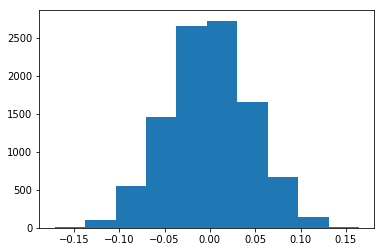

In [29]:
plt.hist(p_diffs);

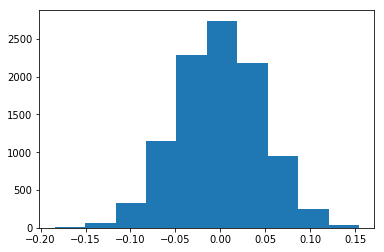

In [30]:
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)
plt.hist(null_vals);

In [31]:
convert_old = df2[df2['landing_page'] == "old_page"].converted == 1
convert_new = df2[df2['landing_page'] == "new_page"].converted == 1
n_old = df2.landing_page == "old_page"
n_new = df2.landing_page == "new_page"
prop_convert_new = convert_new.shape[0] / n_new.shape[0]
prop_convert_old = convert_old.shape[0] / n_old.shape[0]

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [32]:
originalDifference = prop_convert_new - prop_convert_old
(null_vals > originalDifference).mean()

0.49120000000000003

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**We just figured out the p-value of this dataset, which would tell us whether or not to refute the null hypothesis. With our margin of error for Type I errors at 5% (0.05), the probability of error is greater than that, which means we cannot refute the null, which is that the old page is just as good or better than the new one.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [33]:
import statsmodels.api as sm
#Pushed the below stuff upstairs so no need to reinitialize.
#convert_old = df2[df2['landing_page'] == "old_page"].converted == 1
#convert_new = df2[df2['landing_page'] == "new_page"].converted == 1
#n_old = df2.landing_page == "old_page"
#n_new = df2.landing_page == "new_page"

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [34]:
#I've used this, but I'm not sure if this is done correctly. 
#I think my end answer to (n) is still correct however
z_score, p_value = sm.stats.proportions_ztest([convert_old.shape[0], convert_new.shape[0]],[n_old.shape[0], n_new.shape[0]])

from scipy.stats import norm

# Tells us how significant our z-score is
print(norm.cdf(z_score))

#Tells us what our critical value at 95% confidence (5% error rate) is
print(norm.ppf(1-(0.05/2)))

z_score, p_value

0.462377603979
1.95996398454


(-0.094445582555802571, 0.92475520795783672)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The Z-Score is smaller than the critical value, which means we cannot refute the null hypothesis, which states that the old page is just as good or better than the new pages. Likewise, the P-Value is at .92, which is a lot greater than 0.05, which means we cannot refute the null hypothesis, agreeing with our position from the earlier questions.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression, which predicts only two outcomes, in this case, conversion or no conversion.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [35]:
import statsmodels.api as sm
import seaborn as sb

df2["intercept"] = 1
df2["ab_page"] = pd.get_dummies(df2.group == "treatment", drop_first = True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [36]:
model = sm.Logit(df2["converted"], df2[["intercept","ab_page"]])
results = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [37]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 05 Jan 2019   Pseudo R-squ.:               8.077e-06
Time:                        00:44:31   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>

**The p-value comes out to be 0.19. This p-value isn't describing the entire dataset, but the relationship between (in this case) the page and whether or not there was a conversion - hence the difference in values. To specify, the point of modeling this data is to see if there is a significant difference in conversion based on which page a customer receives. Thus, we can frame our H0 and H1 as:**

1. Null: The old page is better or as good at converting users.
2. Alt: The new page is better than the old page at converting users.

**Thus, we can see that since the p-value is 0.19 and above our usual 0.05% threshold, the regression model is saying that the alternate hypothesis is false (the page is not statistically significant), and that we cannot refute the null hypothesis.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Depending on what data we have, sure, I can see why adding other elements might affect whether or not a user converts, and thus be useful in analysis. For example, perhaps the time of day matters, or whether or not this is a users first visit. The latter will have more weight, as someone who is new wouldn't care much for the change because he wouldn't know there was a change or have no trouble switching, while someone who has been using the site for a while will definitely be more hesitant to change - something I experienced very recently with Microsofts rebrand of VSTS to Azure Devops.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [38]:
countries = pd.read_csv("countries.csv")
df2 = df2.set_index('user_id').join(countries.set_index('user_id'))

In [39]:
df2.columns

Index(['timestamp', 'group', 'landing_page', 'converted', 'intercept',
       'ab_page', 'country'],
      dtype='object')

In [40]:
df2.country.value_counts()
dfC = df2

In [41]:
df2[["countryA", "countryB"]] = pd.get_dummies(df2.country, drop_first = True)

In [42]:
model2 = sm.Logit(df2["converted"], df2[["intercept","countryA", "countryB"]])
results2 = model2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sat, 05 Jan 2019   Pseudo R-squ.:               1.521e-05
Time:                        00:44:32   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
countryA       0.0507      0.028      1.786      0.074      -0.005       0.106
countryB       0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

**Looking at the data, we again see that the p-values for the countries are greater than alpha, and thus statistically insignificant. To be safe, I have tried to use country C as well, with the same results.**

In [43]:
dfC[["countryA", "countryB", "countryC"]] = pd.get_dummies(df2.country)
dfC = dfC.drop("countryB", 1)
modelC = sm.Logit(df2["converted"], df2[["intercept","countryA", "countryC"]])
resultsC = modelC.fit()
resultsC.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sat, 05 Jan 2019   Pseudo R-squ.:               1.521e-05
Time:                        00:44:33   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9868      0.011   -174.174      0.000      -2.009      -1.964
countryA      -0.0507      0.028     -1.786      0.074      -0.106       0.005
countryC      -0.0099      0.013     -0.746      0.456      -0.036       0.016
==============================================================================
"""

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [44]:
model3 = sm.Logit(df2["converted"], df2[["intercept", "ab_page", "countryA", "countryB"]])
result3 = model3.fit()
result3.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 05 Jan 2019   Pseudo R-squ.:               2.323e-05
Time:                        00:44:34   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
countryA      -0.0408      0.027     -1.516      0.130      -0.093       0.012
countryB       0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

### Conclusions

**Looking at the above results, the country doesn't seem to have any significance on conversion. Overall, it seems that the new and old page have little effect on conversion. This means, unless there's a specific reason to use the new page, threre isn't enough evidence to deploy it since the old page performs just as well.**

We looked at a few conversion rates:

-  Probability of conversion: 11.9%
-  Probability of control group converting: 12%
-  Probability of treatment group converting: 11.9%

We looked at the differences between our boostrapped differences vs the population differences and found little to separate them:


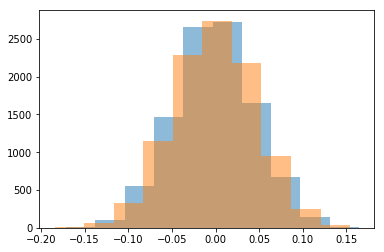

In [45]:
plt.hist(p_diffs, alpha=0.5);
plt.hist(null_vals, alpha=0.5);

We worked through the same examples through Logistic Regression, this time including country to see if that had any effect:

In [51]:
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sat, 05 Jan 2019   Pseudo R-squ.:               1.521e-05
Time:                        00:48:37   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
countryA       0.0507      0.028      1.786      0.074      -0.005       0.106
countryB       0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

With the P-Value > 0.5 , we identified that this isn't particularly significant - that is, the page doesn't have any significance on whether or not a conversion happened.

<b>Thus, we can conclude that conversion is independent of these factors, and our null hypothesis - the old page is just as good or better than the new page at conversion - cannot be refuted.<b> 
<br>
<b>I'd suggest that unless there are other business reasons, there aren't any practical reasons to spend time or money on deploying this new page. If a 12% conversion rate - over 11 - is of absolute significance, then perhaps it's viable to do so. <b>
<br>

In [95]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0